# Baseline Model

This script applies an XGBoost model giving a baseline preformance for comparison.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import json

import xgboost as xgb

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pmdarima import auto_arima
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '\config-example.json', 'r') as f:
    config = json.load(f)

dataset_EDA_fname = config['DEFAULT']['dataset_EDA_fname']
processing_path = config['DEFAULT']['processing_path']
dataset_fname_suffix = config['DEFAULT']['dataset_fname_suffix']

In [ ]:
client_data = pd.read_csv(os.path.join(processing_path,dataset_EDA_fname) + dataset_fname_suffix, header = 0, delimiter = ',')

In [12]:
client_data['StartDate'] = pd.to_datetime(client_data['StartDate'], infer_datetime_format=True)
client_data['StatusCreatedDate'] = pd.to_datetime(client_data['StatusCreatedDate'], infer_datetime_format=True)

# XGBoost

### Weekly Sales 2

#### What is the weekly purchase distribution for each week to predict the weekly sales

We want to know the purchase distribution (StatusCreatedDate) for each EventId with unique start dates along with the weeks to event for when peaople started to buy the tickets.

In [13]:
weekly_ticket_sales = client_data.groupby(['StatusCreatedDate','StartDate','EventType','Weeks to Event'], as_index=False).agg(Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count'))

weekly_ticket_sales

,StatusCreatedDate,StartDate,EventType,Weeks to Event,Num_of_ticket
0,2017-01-11 16:00:00,2017-11-27 00:00:00,"Others, Group 1",46.0,4
1,2017-01-11 16:02:00,2017-11-27 00:00:00,"Others, Group 1",46.0,2
2,2017-01-11 16:20:00,2017-11-25 00:00:00,"Others, Group 1",45.0,2
3,2017-01-11 16:56:00,2017-11-27 00:00:00,"Others, Group 1",46.0,2
4,2017-01-11 17:14:00,2017-11-25 00:00:00,"Others, Group 1",45.0,2
...,...,...,...,...,...
211932,2022-12-20 09:07:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211933,2022-12-20 11:18:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211934,2022-12-21 13:38:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211935,2023-01-13 13:47:00,2023-01-17 14:30:00,"Others, Group 10",1.0,2


We want to get the purchase distribution on a weekly basis across all years for all EventTypes to the weekst to Event start date for when people started purchasing. This shows the purchase distribution on a weekly basis towards the weeks started purchasing for an event.

In [14]:
df_new1 = weekly_ticket_sales.set_index('StatusCreatedDate')
df1 = df_new1.groupby(['Weeks to Event','EventType']).resample('w')['Num_of_ticket'].sum()
df1 = df1.to_frame().reset_index()
# df1 = df1.set_index('StatusCreatedDate')
df1

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket
0,0.0,Colloquium,2021-11-28,10
1,0.0,Colloquium,2021-12-05,0
2,0.0,Colloquium,2021-12-12,0
3,0.0,Colloquium,2021-12-19,0
4,0.0,Colloquium,2021-12-26,0
...,...,...,...,...
13407,66.0,Seminar,2021-02-14,2
13408,67.0,Seminar,2021-01-17,2
13409,70.0,Seminar,2021-01-10,10
13410,70.0,Seminar,2021-01-17,2


### Encoding Categorical Varibles
When training a machine learning model, all categorical variables must be convert into numeric form. Here, the `LabelEncoder` is used.

In [15]:
# Get all categorical variales

categorical_col2 = df1.columns[df1.dtypes == "object"].to_list()
categorical_col2

['EventType']

In [16]:
LE = LabelEncoder()

decode2 = pd.DataFrame(df1[categorical_col2[0]].unique())

for col2 in categorical_col2:
    # Transoform to numeric form
    df1[col2] = LE.fit_transform(df1[col2])

decoded2 = pd.DataFrame(df1[categorical_col2[0]].unique())

final_df2 = pd.DataFrame()
final_df2['decode2'] = decode2
final_df2['decoded2'] = decoded2


dict_encoder = {}

for item in decoded2[0]:
    dict_encoder[final_df2.iloc[item]['decode2']] = item
    
with open("eventtype_encoder1.json", "a") as write_file:
    json.dump(dict_encoder, write_file, indent=4,sort_keys=True)

print(final_df2)

                   decode2  decoded2
0              Colloquium          0
1   Conference / Symposium         1
2               Exhibition         2
3                  Lecture         3
4        Lunchtime Lecture         4
5             Other Events         5
6          Others, Group 1         6
7         Others, Group 10         7
8          Others, Group 2         8
9          Others, Group 3         9
10         Others, Group 4        10
11         Others, Group 5        11
12         Others, Group 6        12
13         Others, Group 7        13
14         Others, Group 8        14
15         Others, Group 9        15
16           Reading Group        16
17       Research Training        17
18                 Seminar        18
19            Short Course        19
20           Summer School        20
21                Workshop        21


In [17]:
df1.head(3)

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket
0,0.0,0,2021-11-28,10
1,0.0,0,2021-12-05,0
2,0.0,0,2021-12-12,0


### Feature Collection

In [19]:
def create_features(df):
    '''
    Create time series features based on time series StatusCreatedDate
    '''
    df['StatusCreatedDayofWeek'] = df.StatusCreatedDate.dt.dayofweek
    df['StatusCreatedQuarter'] = df.StatusCreatedDate.dt.quarter
    df['StatusCreatedDayofyear'] = df.StatusCreatedDate.dt.dayofyear
    df['StatusCreatedMonth'] = df.StatusCreatedDate.dt.month
    df['StatusCreatedYear'] = df.StatusCreatedDate.dt.year
    df['StatusCreatedDayofMonth'] = df.StatusCreatedDate.dt.day
    df['StatusCreatedWeekofYear'] = df.StatusCreatedDate.dt.weekofyear
    return df

In [ ]:
df1 = create_features(df1)

In [21]:
df1.head(3)

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket,StatusCreatedDayofWeek,StatusCreatedQuarter,StatusCreatedDayofyear,StatusCreatedMonth,StatusCreatedYear,StatusCreatedDayofMonth,StatusCreatedWeekofYear
0,0.0,0,2021-11-28,10,6,4,332,11,2021,28,47
1,0.0,0,2021-12-05,0,6,4,339,12,2021,5,48
2,0.0,0,2021-12-12,0,6,4,346,12,2021,12,49


### Train Test Split

In [22]:
train_weekly_ticket_sales, test_weekly_ticket_sales = train_test_split(df1, test_size=0.3, shuffle=False)

### Creating Model

In [23]:
# Creating feauture and sample 


FEATURES_S = ['EventType','StatusCreatedDayofWeek','StatusCreatedQuarter','StatusCreatedDayofyear','StatusCreatedMonth','StatusCreatedYear','StatusCreatedDayofMonth','StatusCreatedWeekofYear','Weeks to Event']
TARGET_S = 'Num_of_ticket'

In [24]:
# Creating X and y train and test
X_train_weekly_ticket_sales = train_weekly_ticket_sales[FEATURES_S]
y_train_weekly_ticket_sales = train_weekly_ticket_sales[TARGET_S]

X_test_weekly_ticket_sales = test_weekly_ticket_sales[FEATURES_S]
y_test_weekly_ticket_sales = test_weekly_ticket_sales[TARGET_S]

In [25]:
reg_weekly_ticket_sales = xgb.XGBRegressor(base_score=0.5, 
                                                # booster='gbtree',
                                                n_estimators=1000, 
                                                early_stopping_rounds=50,
                                                learning_rate=0.01, 
                                                # objective='reg:linear', 
                                                # max_depth=3
                                                )
reg_weekly_ticket_sales.fit(X_train_weekly_ticket_sales, y_train_weekly_ticket_sales, 
        eval_set=[(X_train_weekly_ticket_sales, y_train_weekly_ticket_sales), (X_test_weekly_ticket_sales, y_test_weekly_ticket_sales)],
        verbose=True)

[0]	validation_0-rmse:257.07870	validation_1-rmse:71.24487
[1]	validation_0-rmse:255.80813	validation_1-rmse:71.19877
[2]	validation_0-rmse:254.54534	validation_1-rmse:71.15383
[3]	validation_0-rmse:253.30331	validation_1-rmse:71.11003
[4]	validation_0-rmse:252.06936	validation_1-rmse:71.06736
[5]	validation_0-rmse:250.84949	validation_1-rmse:71.02578
[6]	validation_0-rmse:249.65218	validation_1-rmse:70.98529
[7]	validation_0-rmse:248.46238	validation_1-rmse:70.94585
[8]	validation_0-rmse:247.25370	validation_1-rmse:70.89713
[9]	validation_0-rmse:246.05803	validation_1-rmse:70.85267
[10]	validation_0-rmse:244.87460	validation_1-rmse:70.80938
[11]	validation_0-rmse:243.70352	validation_1-rmse:70.76723
[12]	validation_0-rmse:242.54462	validation_1-rmse:70.72619
[13]	validation_0-rmse:241.39825	validation_1-rmse:70.68625
[14]	validation_0-rmse:240.26335	validation_1-rmse:70.65131
[15]	validation_0-rmse:239.14102	validation_1-rmse:70.61347
[16]	validation_0-rmse:238.03015	validation_1-rmse

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Features Importance

In [26]:
fi1 = pd.DataFrame(data=reg_weekly_ticket_sales.feature_importances_,
                index=reg_weekly_ticket_sales.feature_names_in_,
                columns=['importance'])

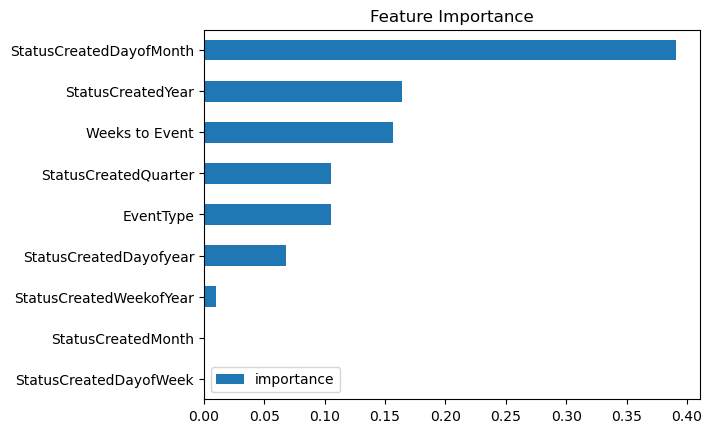

In [28]:
fi1.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [30]:

test_weekly_ticket_sales['XGB_NumofTicket'] = reg_weekly_ticket_sales.predict(X_test_weekly_ticket_sales)


### Storing Predictions

### Forcast on Test

Text(0.5, 1.0, 'Raw Num of Tickets and Predicted Num of Tickets - XGBoost')

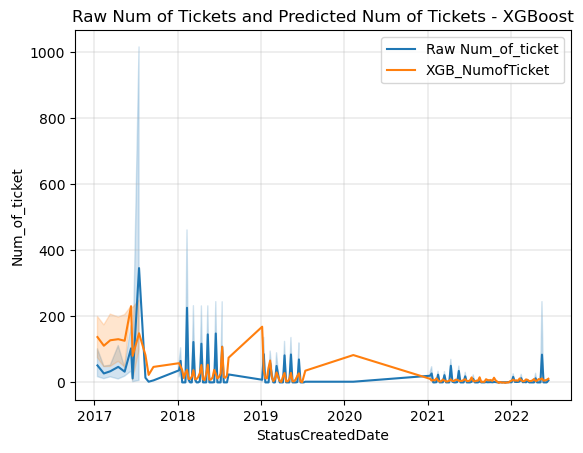

In [33]:
# sns.set(rc={'figure.figsize':(20,10)})

ax = sns.lineplot(x = 'StatusCreatedDate', y = 'Num_of_ticket',data= test_weekly_ticket_sales, label="Raw Num_of_ticket")
ax2 = sns.lineplot(x = 'StatusCreatedDate', y = 'XGB_NumofTicket',data= test_weekly_ticket_sales, label="XGB_NumofTicket")

plt.grid(linestyle='-',linewidth=0.3)
plt.legend()
plt.title('Raw Num of Tickets and Predicted Num of Tickets - XGBoost')

Text(0.5, 1.0, 'Raw Num of Tickets and Predicted Num of Tickets (Weeks to Event) - XGBoost')

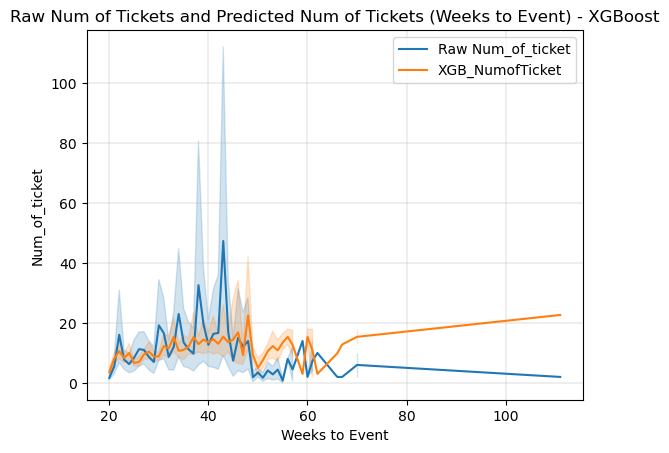

In [34]:
ax = sns.lineplot(x = test_weekly_ticket_sales['Weeks to Event'], y = test_weekly_ticket_sales['Num_of_ticket'],data= test_weekly_ticket_sales, label="Raw Num_of_ticket")
ax2 = sns.lineplot(x = test_weekly_ticket_sales['Weeks to Event'], y = test_weekly_ticket_sales['XGB_NumofTicket'],data= test_weekly_ticket_sales, label="XGB_NumofTicket")

plt.grid(linestyle='-',linewidth=0.3)
plt.legend()
plt.title('Raw Num of Tickets and Predicted Num of Tickets (Weeks to Event) - XGBoost')

Save model

In [49]:
reg_weekly_ticket_sales.save_model("weekly_sales_model.json")